# 2.Cut_Mix.ipynb 說明
本 notebook 主要教學如何在影像分類任務中實作 CutMix 資料增強技術。內容重點如下：
1. **CutMix 理論簡介**：CutMix 是一種資料增強方法，將一張圖片的隨機區塊貼到另一張圖片上，標籤也依照區塊面積比例混合，能提升模型泛化能力、降低過擬合。
2. **PyTorch 實作**：示範如何用 PyTorch 對影像與標籤進行 CutMix 操作，並整合到訓練流程中。
3. **資料前處理與載入**：包含資料集的下載、前處理（如正規化、資料增強）與 DataLoader 建立。
4. **模型訓練與驗證**：設計訓練流程，記錄 loss 與 accuracy，並可視覺化訓練過程。
5. **CutMix 效果觀察**：比較有無 CutMix 的訓練結果，觀察其對模型表現的影響。
本 notebook 適合用於理解現代深度學習中的資料增強技巧，並學習如何將 CutMix 實際應用於影像分類專案。

**資料來源 :**
https://arxiv.org/pdf/1905.04899.pdf

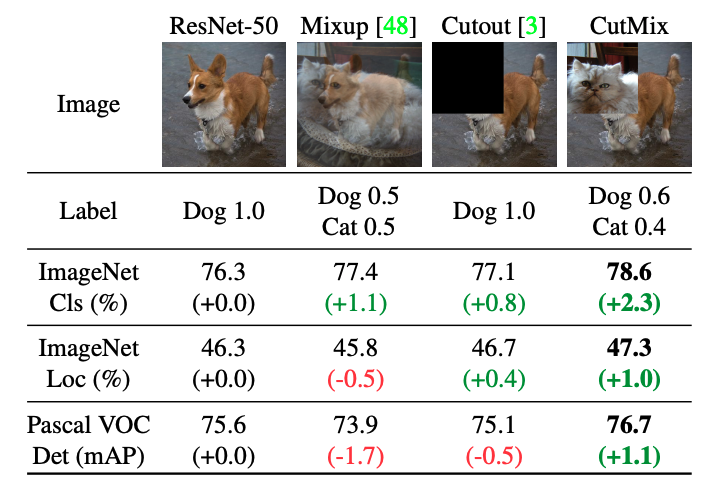

In [ ]:
# import package
import os
import cv2
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchtoolbox.optimizer import CosineWarmupLr
from torchsummary import summary
import pandas as pd

In [ ]:
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")# 使用mac m1 晶片
device

# 一、資料讀取與處理

In [ ]:
import gdown

# url = "https://drive.google.com/u/1/uc?id=1ND85Qa01QNNirv9NxLS_L90O3mTBpaX6&export=download"
# output = "cats_dogs.zip"
# gdown.download(url, output, quiet=False)

## 1. 解壓縮資料集

In [ ]:
# !unzip -qq cats_dogs.zip

# 二、實際使用Cut Mix來訓練一個貓狗分類模型吧！

## 1. 將訓練集與測試集讀取進來

- 主要會將圖片的路徑以及圖片的標籤儲存在陣列裡面
    - x_data_list : 陣列，儲存圖片路徑
    - y_data_list : 陣列，儲存圖片標籤

In [ ]:
image_shape = 128

In [ ]:
Trainloc = './dataset/training_set' #訓練集的路徑
Testloc = './dataset/test_set'      #測試集的路徑

In [ ]:
def DirToDataFrame(data_path):
    x_data_list = []
    y_data_list = []

    for label in os.listdir(data_path):                           #找出第一層的folder，也就是貓還是狗的folder
        for img in os.listdir(os.path.join(data_path,label)):     #貓與狗folder裡面的圖片
            if img[-4:] == '.jpg':
                x_data_list.append(os.path.join(data_path,label,img)) #將圖片路徑儲存在x_data_list
                y_data_list.append(label)                             #將標籤儲存在y_data_list

    data_list = pd.DataFrame({})
    data_list['img_path'] = x_data_list
    data_list['label'] = y_data_list
    return data_list, x_data_list, y_data_list

In [ ]:
Traindf, Train_img, Train_label = DirToDataFrame(Trainloc)
Testdf, Test_img, Test_label = DirToDataFrame(Testloc)

In [ ]:
print(Traindf.groupby('label').size().sort_values())
print(Testdf.groupby('label').size().sort_values())

## 2. 標籤的Number Encoding

在模型中，需要將標籤轉換成數字才能做訓練，以`dog`與`cat`為例，需要將其轉換成0以及1。

所以我們建立一個字典，如：{'dogs': 0, 'cats': 1}，讓他可以在data loader中作轉換。

In [ ]:
label_dict = {}

Count = 0
for i in range(len(Traindf)):
    if Traindf.iloc[i].label in label_dict:
        continue
    else:
        label_dict[Traindf.iloc[i].label] = Count
        Count += 1
print(label_dict)

In [ ]:
labelreverse = {v: k for k, v in label_dict.items()}
labelreverse

## 3. 建立預處理功能以及建立data loader

有一個很大的重點，訓練集可以做資料預處理及各式各樣的資料擴增，但驗證或是測試集僅能做資料預處理

In [ ]:
# 訓練集的預處理及資料擴增
# resize的default為PIL.Image.BILINEAR
preprocess_train = transforms.Compose([transforms.ToTensor(),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.Resize((image_shape,image_shape))])
                                       #transforms.RandomResizedCrop((image_shape,image_shape))])

# 測試集的預處理
preprocess_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((image_shape,image_shape))])

In [ ]:
def default_loader(path, preprocess_function):
    # 使用cv2讀取圖片
    img_pil = cv2.imread(path)
    # 將BGR 轉換成 RGB
    img_pil = cv2.cvtColor(img_pil, cv2.COLOR_BGR2RGB)
    # 將前面的預處理方式加入圖片中
    img_tensor = preprocess_function(img_pil)
    return img_tensor

In [ ]:
class Custom_Generator(Dataset):
    def __init__(self, image_file, image_label, label_dict, pre_fn, loader = default_loader):

        self.images = image_file      # 圖片路徑的陣列
        self.target = image_label     # 圖片標籤的陣列
        self.label_dict = label_dict  # 如：{'dogs': 0, 'cats': 1}
        self.pre_fn = pre_fn          # 資料預處理
        self.loader = loader          # 讀圖片的function

    def __getitem__(self, index):
        fn = self.images[index]      # 圖片路徑

        img = self.loader(path = fn, # 圖片讀取以及預處理後的結果，輸入模型用
                          preprocess_function = self.pre_fn)

        target = self.label_dict[self.target[index]] # 圖片標籤, 並轉換成數字

        return img,target

    def __len__(self):
        return len(self.images)     # 回傳資料集數量

In [ ]:
# 1. 先呼叫我們寫好的Custom_Generator, 將圖片的路徑陣列、圖片的標籤陣列以及預處理功能放入裡面
train_data  = Custom_Generator(image_file = Train_img,
                               image_label = Train_label,
                               label_dict = label_dict,
                               pre_fn = preprocess_train)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
# num_workers : 表示開啟多少個線程數去加載你的數據，默認為0，代表只使用主進程。
# pin_memory : 表示要將load進來的數據是否要拷貝到pin_memory區中，其表示生成的Tensor數據是屬於內存中的鎖頁內存區，這樣將Tensor數據轉義到GPU中速度就會快一些，默認為False。
trainloader = DataLoader(train_data, batch_size=32,shuffle=True, num_workers = 3, pin_memory = True, persistent_workers=True)

# 1. 先呼叫我們寫好的Custom_Generator, 將圖片的路徑陣列、圖片的標籤陣列以及預處理功能放入裡面
test_data  = Custom_Generator(image_file = Test_img,
                              image_label = Test_label,
                              label_dict = label_dict,
                              pre_fn = preprocess_test)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
testloader = DataLoader(test_data, batch_size=32,shuffle=False)



## 4. 查看訓練集圖片

In [ ]:
train_dataiter = iter(trainloader)   #迭代器
images,labels = next(train_dataiter)

In [ ]:
plt.gcf().set_size_inches(20, 20)

for i in range(images.shape[0]):
    img_show = plt.subplot(6, 6, i+1)
    plt.imshow(np.transpose(images[i],(1,2,0)))
    plt.title(labels[i])

## 5. CutMix 方法

In [ ]:
# 設定的random bounding box
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
# 設定一個隨機值，beat分佈，拋一次正面一次反面就推測硬幣概率，決定併進來的圖片的大小
lam = np.random.beta(1,1)
# 假設input的圖片有4張，就隨機打亂4個數字, 如原本為[0,1,2,3], 會變成[1,3,0,2]
rand_index = torch.randperm(images.size()[0]).cpu()
# 取出隨機裁減出來的圖片座標，會將此座標直接貼上另外一張圖片
bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
print(bbx1, bby1, bbx2, bby2)
# 將隨機的一張圖併進去原圖中 images的維度為[batch_size, channel, width, height]
images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
# 依照pixel大小決定標籤的大小
lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
print(lam, 1 - lam) #這個數字代表原圖片的標籤機率，1 - lam則為貼上圖片後的標籤機率

In [ ]:
plt.gcf().set_size_inches(20, 20)

for i in range(images.shape[0]):
    img_show = plt.subplot(6, 6, i+1)
    plt.imshow(np.transpose(images[i],(1,2,0)))
    plt.title(labels[i])

## 6. 建立一個簡單的分類模型

In [ ]:
conv_list = [32,32,"DS",64,64,"DS"]

class Model(nn.Module):
    def __init__(self, input_size, conv_list):
        super(Model,self).__init__()

        self.out_size = input_size // 4
        self.conv_list = conv_list
        self.CNN_Feature = self.conv_block()
        self.fc = nn.Sequential(nn.Linear(in_features = 64*self.out_size*self.out_size, out_features = 128),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features = 128, out_features = 10))
        self.flatten = nn.Flatten()

    def conv_block(self):
        layers = []
        in_channel = 3

        for channel in self.conv_list:
            if channel == 'DS':
                layers.append(nn.MaxPool2d(2,2))

            else:
                layers.append(nn.Conv2d(in_channel, channel, kernel_size = 3, padding = 1))
                layers.append(nn.ReLU(inplace=True))
                # 下一次的輸入channel = 現在的輸出channel
                in_channel = channel

        return nn.Sequential(*layers)

    def forward(self,x):

        x = self.CNN_Feature(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

model = Model(input_size = 128, conv_list = conv_list).to(device)
summary(model, input_size=(3, 128, 128))

In [ ]:
# 超參數設定
# criterion : loss function
# lr : learning rate
# epochs : epoch 數量
# optimizer : 優化器

criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 20

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


In [ ]:
def PrintLogMessage(Now_epoch, Total_epoch, Now_itr, Total_itr, loss, acc, train = True, flush = False):
    if train == True and flush == True:
        print('[%02d/%02d, %d/%d] loss: %.3f, acc: %.3f' % (Now_epoch, Total_epoch, Now_itr, Total_itr, loss,acc),end = "")
        print("\r", end="", flush=True)
    elif train == True and flush == False:
        print('[%02d/%02d, %d/%d] loss: %.3f, acc: %.3f' % (Now_epoch, Total_epoch, Now_itr, Total_itr, loss,acc),end = "")
    elif train == False:
        print(', test_loss: %.3f, test_acc: %.3f' % (loss,acc))


## 7. 不使用cut mix 訓練

In [ ]:
# 訓練過程
# len(trainLoader) : 訓練集總共的資料量 / batch
# len(trainLoader.dataset) : 訓練集總共的資料量

NoCut_train_acc = []
NoCut_train_loss = []
NoCut_test_acc = []
NoCut_test_loss = []

for epoch in range(epochs):
    # 訓練階段
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0
    for times, data_train in enumerate(trainloader, 0):
        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # model Feedforward
        output_train = model(inputs)
        # Feed forward loss result
        loss = criterion(output_train, labels)

        # backward update
        loss.backward()

        # optimize
        optimizer.step()

        # Compute loss
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        # Print log message
        PrintLogMessage(Now_epoch = epoch+1,
                        Total_epoch = epochs,
                        Now_itr = times+1,
                        Total_itr = len(trainloader),
                        loss = running_loss/(times+1),
                        acc = accuracy / total,
                        train = True,
                        flush = True)
        if times+1 == len(trainloader):
            # Print log message
            PrintLogMessage(Now_epoch = epoch+1,
                            Total_epoch = epochs,
                            Now_itr = times+1,
                            Total_itr = len(trainloader),
                            loss = running_loss/len(trainloader),
                            acc = accuracy / total,
                            train = True,
                            flush = False)

            NoCut_train_acc.append(accuracy / total)
            NoCut_train_loss.append(running_loss/len(trainloader))
            running_loss = 0.0

    # 測試階段
    model.eval()
    test_loss = 0.0
    accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testloader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)

            # model predict
            output_test = model(inputs)

            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()

            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            if times+1 == len(testloader):
                PrintLogMessage(Now_epoch = epoch+1,
                                Total_epoch = epochs,
                                Now_itr = times+1,
                                Total_itr = len(testloader),
                                loss = test_loss / len(testloader),
                                acc = accuracy / total,
                                train = False,)
                NoCut_test_acc.append(accuracy / total)
                NoCut_test_loss.append(test_loss/len(testloader))
                test_loss = 0.0

print('Finished Training')

## 8. 使用cut mix 訓練

In [ ]:
# 設定的random bounding box
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
model = Model(input_size = 128, conv_list = conv_list).to(device)

In [ ]:
# 超參數設定
# cutmix_prob : 使用cutmix的機率
# criterion : loss function
# lr : learning rate
# epochs : epoch 數量
# optimizer : 優化器

cutmix_prob = 0.5
criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 20

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)



In [ ]:
# 訓練過程
# len(trainLoader) : 訓練集總共的資料量 / batch
# len(trainLoader.dataset) : 訓練集總共的資料量

Cut_train_acc = []
Cut_train_loss = []
Cut_test_acc = []
Cut_test_loss = []

for epoch in range(epochs):
    # 訓練階段
    running_loss = 0.0
    accuracy = 0.0
    total = 0.0
    for times, data_train in enumerate(trainloader, 0):
        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # 設定一個cutmix機率，小於原本超參數的機率則啟用cut mix函式
        random_cutmix_prob = np.random.rand(1)
        if random_cutmix_prob < cutmix_prob:
            # 設定一個隨機值，beat分佈，拋一次正面一次反面就推測硬幣概率，決定併進來的圖片的大小
            lam = np.random.beta(1,1)
            # 假設input的圖片有4張，就隨機打亂4個數字, 如原本為[0,1,2,3], 會變成[1,3,0,2]
            rand_index = torch.randperm(inputs.size()[0]).cuda()
            # 標籤a
            target_a = labels
            # 標籤b
            target_b = labels[rand_index]
            # 取出隨機裁減出來的圖片座標，會將此座標直接貼上另外一張圖片
            bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
            # 將隨機的一張圖併進去原圖中 images的維度為[batch_size, channel, width, height]
            inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
            # 依照pixel大小決定標籤的大小
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))

            # model Feedforward
            output_train = model(inputs)
            # Feed forward loss result
            loss = criterion(output_train, target_a)*lam + criterion(output_train, target_b)*(1. - lam)


        else:
            # model Feedforward
            output_train = model(inputs)
            # Feed forward loss result
            loss = criterion(output_train, labels)

        # backward update
        loss.backward()

        # optimize
        optimizer.step()

        # Compute loss
        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()
        # Print log message
        PrintLogMessage(Now_epoch = epoch+1,
                        Total_epoch = epochs,
                        Now_itr = times+1,
                        Total_itr = len(trainloader),
                        loss = running_loss/(times+1),
                        acc = accuracy / total,
                        train = True,
                        flush = True)
        if times+1 == len(trainloader):
            # Print log message
            PrintLogMessage(Now_epoch = epoch+1,
                            Total_epoch = epochs,
                            Now_itr = times+1,
                            Total_itr = len(trainloader),
                            loss = running_loss/len(trainloader),
                            acc = accuracy / total,
                            train = True,
                            flush = False)
            Cut_train_acc.append(accuracy / total)
            Cut_train_loss.append(running_loss/len(trainloader))
            running_loss = 0.0

    # 測試階段
    model.eval()
    test_loss = 0.0
    accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testloader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)

            # model predict
            output_test = model(inputs)

            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()

            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            if times+1 == len(testloader):
                PrintLogMessage(Now_epoch = epoch+1,
                                Total_epoch = epochs,
                                Now_itr = times+1,
                                Total_itr = len(testloader),
                                loss = test_loss / len(testloader),
                                acc = accuracy / total,
                                train = False,)
                Cut_test_acc.append(accuracy / total)
                Cut_test_loss.append(test_loss/len(testloader))
                test_loss = 0.0

print('Finished Training')

In [ ]:
def Show_Train_flow(ResultA, ResultB, Show = 'loss', Title='Training accuracy comparison'):
    plt.plot(ResultA)
    plt.plot(ResultB)
    plt.title(Title)
    plt.ylabel(Show)
    plt.xlabel('Epoch')
    plt.legend(['Cut Mix','No Cut Mix'])
    plt.show()



Show_Train_flow(Cut_train_acc, NoCut_train_acc, Show = 'Train acc.', Title='Training accuracy comparison')
Show_Train_flow(Cut_test_acc, NoCut_test_acc, Show = 'Test acc.', Title='Testing accuracy comparison')

Show_Train_flow(Cut_train_loss, NoCut_train_loss, Show = 'Train loss', Title='Training loss comparison')
Show_Train_flow(Cut_test_loss, NoCut_test_loss, Show = 'Testing loss', Title='Testing loss comparison')